In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

import warnings
warnings.simplefilter('always', category=UserWarning)

In [2]:
df = pd.read_csv('../../data/cleaned/NFL_wk_by_wk_cleaned.csv')
df.head()

,GAME_ID,WEEK_NUM,GAME_DAY_OF_WEEK,GAME_DATE,GAMETIME,WINNER,GAME_LOCATION,LOSER,BOXSCORE_LINK,PTS_WINNER,...,YARDS_LOSER,TURNOVERS_LOSER,YEAR,STADIUM,ROOF,SURFACE,VEGAS_LINE,OVER_UNDER,FAVORITED,WIN_OR_TIE
0,1991_01_ATL_KAN,1,Sun,1991-09-01,1:00PM,Kansas City Chiefs,NULL_VALUE,Atlanta Falcons,/boxscores/199109010kan.htm,14,...,243,6,1991-1992,Arrowhead Stadium,outdoors,astroturf,-7.0,42.0,Kansas City Chiefs,1.0
1,1991_01_DAL_CLE,1,Sun,1991-09-01,1:00PM,Dallas Cowboys,@,Cleveland Browns,/boxscores/199109010cle.htm,26,...,275,0,1991-1992,Cleveland Municipal Stadium,outdoors,grass,-2.5,36.0,Dallas Cowboys,1.0
2,1991_01_PHI_GB,1,Sun,1991-09-01,1:00PM,Philadelphia Eagles,@,Green Bay Packers,/boxscores/199109010gnb.htm,20,...,228,5,1991-1992,Lambeau Field,outdoors,grass,-2.0,44.0,Philadelphia Eagles,1.0
3,1991_01_SEA_NO,1,Sun,1991-09-01,1:00PM,New Orleans Saints,NULL_VALUE,Seattle Seahawks,/boxscores/199109010nor.htm,27,...,348,4,1991-1992,Louisiana Superdome,dome,astroturf,-4.0,35.0,New Orleans Saints,1.0
4,1991_01_TB_NYJ,1,Sun,1991-09-01,1:00PM,New York Jets,NULL_VALUE,Tampa Bay Buccaneers,/boxscores/199109010nyj.htm,16,...,277,2,1991-1992,Giants Stadium,outdoors,astroturf,-2.5,40.0,New York Jets,1.0


In [3]:
df = df.loc[:,['YEAR','WEEK_NUM','WINNER','LOSER','GAME_LOCATION','PTS_WINNER','PTS_LOSER','WIN_OR_TIE']]
df.columns = ['YEAR', 'WEEK_NUM', 'TEAM_A', 'TEAM_B', 'GAME_LOCATION', 'PTS_TEAM_A','PTS_TEAM_B', 'WIN_OR_TIE']
df.head()

,YEAR,WEEK_NUM,TEAM_A,TEAM_B,GAME_LOCATION,PTS_TEAM_A,PTS_TEAM_B,WIN_OR_TIE
0,1991-1992,1,Kansas City Chiefs,Atlanta Falcons,NULL_VALUE,14,3,1.0
1,1991-1992,1,Dallas Cowboys,Cleveland Browns,@,26,14,1.0
2,1991-1992,1,Philadelphia Eagles,Green Bay Packers,@,20,3,1.0
3,1991-1992,1,New Orleans Saints,Seattle Seahawks,NULL_VALUE,27,24,1.0
4,1991-1992,1,New York Jets,Tampa Bay Buccaneers,NULL_VALUE,16,13,1.0


In [4]:
temp = df.loc[:,['YEAR','WEEK_NUM','TEAM_B','TEAM_A','GAME_LOCATION','PTS_TEAM_B','PTS_TEAM_A','WIN_OR_TIE']].copy()
temp['GAME_LOCATION'] = temp['GAME_LOCATION'].apply(lambda x: '@' if x == 'NULL_VALUE' else 'NULL_VALUE')
temp['WIN_OR_TIE'] = 0
temp.columns = ['YEAR', 'WEEK_NUM', 'TEAM_A', 'TEAM_B', 'GAME_LOCATION', 'PTS_TEAM_A','PTS_TEAM_B', 'WIN_OR_TIE']
temp.head()

,YEAR,WEEK_NUM,TEAM_A,TEAM_B,GAME_LOCATION,PTS_TEAM_A,PTS_TEAM_B,WIN_OR_TIE
0,1991-1992,1,Atlanta Falcons,Kansas City Chiefs,@,3,14,0
1,1991-1992,1,Cleveland Browns,Dallas Cowboys,NULL_VALUE,14,26,0
2,1991-1992,1,Green Bay Packers,Philadelphia Eagles,NULL_VALUE,3,20,0
3,1991-1992,1,Seattle Seahawks,New Orleans Saints,@,24,27,0
4,1991-1992,1,Tampa Bay Buccaneers,New York Jets,@,13,16,0


In [5]:
## Combine the the original df and the flipped df
df = pd.concat([df, temp]).sort_values(['YEAR','WEEK_NUM','TEAM_A','TEAM_B'])

## Set 'LOC' to associated Home or Away
df['LOC'] = np.nan
df['LOC'] = df.loc[:,'GAME_LOCATION'].apply(lambda x: "HOME" if x == 'NULL_VALUE' else "AWAY")

## Create a dictionary of 'Year: last_week_in_that_season'
weeks_by_season = df.loc[:,['YEAR','WEEK_NUM']].groupby('YEAR')['WEEK_NUM'].apply(list)
final_week_in_season = {}
for x in list(zip(weeks_by_season.index,weeks_by_season.apply(lambda x: sorted(list(set(x)))[-1]))):
    final_week_in_season[x[0]] = x[1]

## Remove the current year that we are in since we did not finish the full year
del final_week_in_season['2024-2025']

## for each year's superbowl assign it's location to "neutral"
for k,v in final_week_in_season.items():
    df.loc[(df['YEAR']==k)&(df['WEEK_NUM']==v),"LOC"] = 'NEUTRAL'

## Clean up 
final_week_in_season, weeks_by_season = None, None
del final_week_in_season, weeks_by_season

## Create a points differential column
df['PT_DIFF'] = df['PTS_TEAM_A'] - df['PTS_TEAM_B']

df.head(10)

,YEAR,WEEK_NUM,TEAM_A,TEAM_B,GAME_LOCATION,PTS_TEAM_A,PTS_TEAM_B,WIN_OR_TIE,LOC,PT_DIFF
5,1991-1992,1,Arizona Cardinals,Los Angeles Rams,@,24,14,1.0,AWAY,10
0,1991-1992,1,Atlanta Falcons,Kansas City Chiefs,@,3,14,0.0,AWAY,-11
9,1991-1992,1,Buffalo Bills,Miami Dolphins,NULL_VALUE,35,31,1.0,HOME,4
10,1991-1992,1,Chicago Bears,Minnesota Vikings,NULL_VALUE,10,6,1.0,HOME,4
6,1991-1992,1,Cincinnati Bengals,Denver Broncos,@,14,45,0.0,AWAY,-31
1,1991-1992,1,Cleveland Browns,Dallas Cowboys,NULL_VALUE,14,26,0.0,HOME,-12
1,1991-1992,1,Dallas Cowboys,Cleveland Browns,@,26,14,1.0,AWAY,12
6,1991-1992,1,Denver Broncos,Cincinnati Bengals,NULL_VALUE,45,14,1.0,HOME,31
12,1991-1992,1,Detroit Lions,Washington Commanders,@,0,45,0.0,AWAY,-45
2,1991-1992,1,Green Bay Packers,Philadelphia Eagles,NULL_VALUE,3,20,0.0,HOME,-17


In [6]:
## Summary statistics of home team's point differential
df.loc[df['LOC']=='HOME',['LOC','PT_DIFF']].groupby('LOC').describe()

PT_DIFF                                                
       count      mean       std   min  25%  50%   75%   max
LOC                                                         
HOME  8796.0  2.504661  14.52129 -49.0 -6.0  3.0  11.0  59.0

In [7]:
## Let's look at the most common Home team point differential by each year 
df.loc[df['LOC']=='HOME',['YEAR','PT_DIFF','LOC']].groupby(['YEAR','PT_DIFF']).count().reset_index().sort_values('LOC',ascending=False).head(20)

,YEAR,PT_DIFF,LOC
1692,2018-2019,3,32
266,1995-1996,3,28
1180,2010-2011,-3,28
989,2007-2008,3,28
382,1997-1998,3,27
1945,2022-2023,3,27
561,2000-2001,3,26
932,2006-2007,3,26
1119,2009-2010,3,26
1505,2015-2016,3,26


/home/thursty/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/thursty/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/thursty/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/thursty/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/thursty/.l

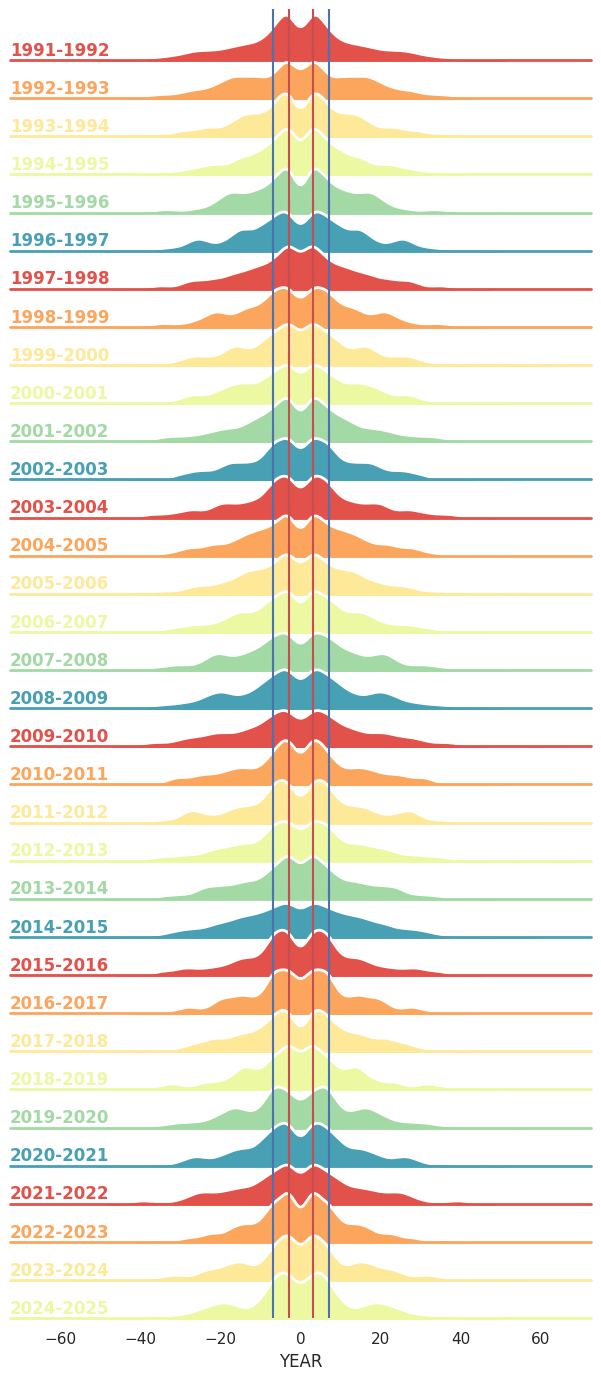

In [ ]:
# Initialize the FacetGrid object
pal = sns.color_palette("Spectral", as_cmap=False)
g = sns.FacetGrid(df, row="YEAR", hue="YEAR", aspect=15, height=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "PT_DIFF",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "PT_DIFF", clip_on=False, color="w", lw=2, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "YEAR")

# Win by field goal
g.map(plt.axvline, x=3, color='r', linestyle='-')
g.map(plt.axvline, x=-3, color='r', linestyle='-')

g.map(plt.axvline, x=7, color='b', linestyle='-')
g.map(plt.axvline, x=-7, color='b', linestyle='-')



# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

In [17]:
## Checking to see if grouping the seasons into groups of 5 makes any patterns appear
temp = df.loc[df['LOC']=='HOME',['YEAR','PT_DIFF','LOC']]#.groupby(['YEAR','PT_DIFF']).count().reset_index()
temp['YEAR'] = temp['YEAR'].map({   '1991-1992':'1991-1995',
                                    '1992-1993':'1991-1995',
                                    '1993-1994':'1991-1995',
                                    '1994-1995':'1991-1995',
                                    '1995-1996':'1991-1995',
                                    '1996-1997':'1996-2000',
                                    '1997-1998':'1996-2000',
                                    '1998-1999':'1996-2000',
                                    '1999-2000':'1996-2000',
                                    '2000-2001':'1996-2000',
                                    '2001-2002':'2001-2005',
                                    '2002-2003':'2001-2005',
                                    '2003-2004':'2001-2005',
                                    '2004-2005':'2001-2005',
                                    '2005-2006':'2001-2005',
                                    '2006-2007':'2006-2010',
                                    '2007-2008':'2006-2010',
                                    '2008-2009':'2006-2010',
                                    '2009-2010':'2006-2010',
                                    '2010-2011':'2006-2010',
                                    '2011-2012':'2011-2015',
                                    '2012-2013':'2011-2015',
                                    '2013-2014':'2011-2015',
                                    '2014-2015':'2011-2015',
                                    '2015-2016':'2011-2015',
                                    '2016-2017':'2016-2020',
                                    '2017-2018':'2016-2020',
                                    '2018-2019':'2016-2020',
                                    '2019-2020':'2016-2020',
                                    '2020-2021':'2016-2020',
                                    '2021-2022':'2021-2025',
                                    '2022-2023':'2021-2025',
                                    '2023-2024':'2021-2025',
                                    '2024-2025':'2021-2025'})
# temp = temp.groupby(['YEAR','PT_DIFF']).sum().reset_index()
temp

,YEAR,PT_DIFF,LOC
9,1991-1995,4,HOME
10,1991-1995,4,HOME
1,1991-1995,-12,HOME
6,1991-1995,31,HOME
2,1991-1995,-17,HOME
...,...,...,...
8806,2021-2025,-1,HOME
8802,2021-2025,8,HOME
8803,2021-2025,2,HOME
8812,2021-2025,-3,HOME


/home/thursty/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/thursty/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/thursty/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/thursty/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/thursty/.l

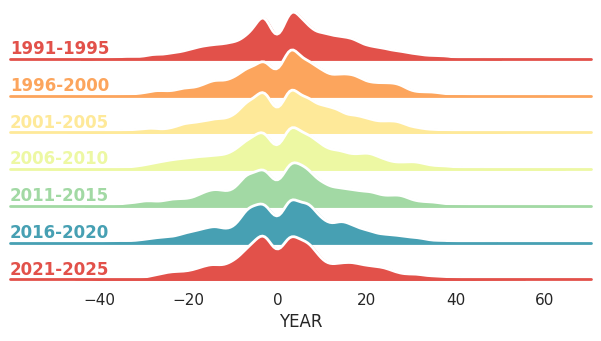

In [18]:
# Initialize the FacetGrid object
pal = sns.color_palette("Spectral", as_cmap=False)
g = sns.FacetGrid(temp, row="YEAR", hue="YEAR", aspect=15, height=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "PT_DIFF",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "PT_DIFF", clip_on=False, color="w", lw=2, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# # Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "YEAR")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

plt.show()

In [29]:
from sklearn import linear_model

In [19]:
df.head()

,YEAR,WEEK_NUM,TEAM_A,TEAM_B,GAME_LOCATION,PTS_TEAM_A,PTS_TEAM_B,WIN_OR_TIE,LOC,PT_DIFF
5,1991-1992,1,Arizona Cardinals,Los Angeles Rams,@,24,14,1.0,AWAY,10
0,1991-1992,1,Atlanta Falcons,Kansas City Chiefs,@,3,14,0.0,AWAY,-11
9,1991-1992,1,Buffalo Bills,Miami Dolphins,NULL_VALUE,35,31,1.0,HOME,4
10,1991-1992,1,Chicago Bears,Minnesota Vikings,NULL_VALUE,10,6,1.0,HOME,4
6,1991-1992,1,Cincinnati Bengals,Denver Broncos,@,14,45,0.0,AWAY,-31


In [20]:
df_elo = pd.read_csv('../../data/cleaned/NFL_Team_Elo.csv')
df_elo.head()

,NFL_TEAM,NFL_YEAR,NFL_WEEK,ELO
0,Arizona Cardinals,1991-1992,1,1500.0
1,Atlanta Falcons,1991-1992,1,1500.0
2,Buffalo Bills,1991-1992,1,1500.0
3,Chicago Bears,1991-1992,1,1500.0
4,Cincinnati Bengals,1991-1992,1,1500.0


In [26]:
temp = pd.merge(df, df_elo, how='left', left_on=['YEAR','WEEK_NUM','TEAM_A'], right_on=['NFL_YEAR','NFL_WEEK','NFL_TEAM'])
temp.columns = ['YEAR', 'WEEK_NUM', 'TEAM_A', 'TEAM_B', 'GAME_LOCATION', 'PTS_TEAM_A','PTS_TEAM_B', 'WIN_OR_TIE', 'LOC', 'PT_DIFF', 'NFL_TEAM', 'NFL_YEAR','NFL_WEEK', 'TEAM_A_ELO']
temp = temp.drop(['NFL_TEAM','NFL_YEAR','NFL_WEEK'],axis=1)
temp = pd.merge(temp, df_elo, how='left', left_on=['YEAR','WEEK_NUM','TEAM_B'], right_on=['NFL_YEAR','NFL_WEEK','NFL_TEAM'])
temp.columns = ['YEAR', 'WEEK_NUM', 'TEAM_A', 'TEAM_B', 'GAME_LOCATION', 'PTS_TEAM_A','PTS_TEAM_B', 'WIN_OR_TIE', 'LOC', 'PT_DIFF', 'TEAM_A_ELO', 'NFL_TEAM','NFL_YEAR', 'NFL_WEEK', 'TEAM_B_ELO']
temp = temp.drop(['NFL_TEAM','NFL_YEAR','NFL_WEEK'],axis=1)
temp['ELO_DIFF'] = temp['TEAM_A_ELO'] - temp['TEAM_B_ELO']
temp

,YEAR,WEEK_NUM,TEAM_A,TEAM_B,GAME_LOCATION,PTS_TEAM_A,PTS_TEAM_B,WIN_OR_TIE,LOC,PT_DIFF,TEAM_A_ELO,TEAM_B_ELO,ELO_DIFF
0,1991-1992,1,Arizona Cardinals,Los Angeles Rams,@,24,14,1.0,AWAY,10,1500.000000,1500.000000,0.000000
1,1991-1992,1,Atlanta Falcons,Kansas City Chiefs,@,3,14,0.0,AWAY,-11,1500.000000,1500.000000,0.000000
2,1991-1992,1,Buffalo Bills,Miami Dolphins,NULL_VALUE,35,31,1.0,HOME,4,1500.000000,1500.000000,0.000000
3,1991-1992,1,Chicago Bears,Minnesota Vikings,NULL_VALUE,10,6,1.0,HOME,4,1500.000000,1500.000000,0.000000
4,1991-1992,1,Cincinnati Bengals,Denver Broncos,@,14,45,0.0,AWAY,-31,1500.000000,1500.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17627,2024-2025,11,Pittsburgh Steelers,Baltimore Ravens,NULL_VALUE,18,16,1.0,HOME,2,1535.005456,1563.329959,-28.324504
17628,2024-2025,11,San Francisco 49ers,Seattle Seahawks,NULL_VALUE,17,20,0.0,HOME,-3,1548.201642,1471.815226,76.386415
17629,2024-2025,11,Seattle Seahawks,San Francisco 49ers,@,20,17,1.0,AWAY,3,1471.815226,1548.201642,-76.386415
17630,2024-2025,11,Tennessee Titans,Minnesota Vikings,NULL_VALUE,13,23,0.0,HOME,-10,1404.136893,1519.132774,-114.995881


In [32]:
regression_data = temp.loc[temp['YEAR']!='1991-1992',['ELO_DIFF','PT_DIFF']]
reg = linear_model.LinearRegression()
reg.fit(regression_data['ELO_DIFF'].values.reshape(-1,1), regression_data['PT_DIFF'].values.reshape(-1,1))


LinearRegression()

In [33]:
reg.coef_

array([[0.05818386]])

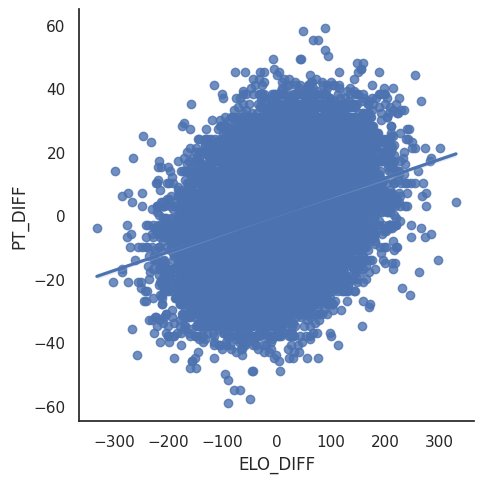

In [35]:
sns.lmplot(x='ELO_DIFF', y='PT_DIFF', data=regression_data)